## Peak finder
Take in csv file of motif distribution for a cell sample. Detect the regions with enrichment of motif counts within a row of motif distribution.

#### Import library

In [74]:
import csv
import math
import numpy as np
from pf_lib1 import find_peaks_and_or_valleys, plot_raw_data, plot_peaks_and_valleys
import argparse
import sys
# from file_reader import read_mds_file

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 300em; }</style>"))
# extend the scroll

In [75]:
def input_parser():
    '''
    This fuction allows you to choose method you want
    '''
    parser = argparse.ArgumentParser()

    # Motif distribution (MD) method
    parser.add_argument(
        '-m',
        '--Motif_distribution',
        help="This option allows you choose original method",
        required=False
    )

    # Exponential method
    parser.add_argument(
        '-e',
        '--exponential',
        help="This option allows you choose exponential method",
        required=False
    )

    # Self Exponential method
    parser.add_argument(
        '-s',
        '--self_exponential',
        help="This option allows you choose self exponential method",
        required=False
    )

    # FFT method
    parser.add_argument(
        '-f',
        '--FFT',
        help="This option allows you choose FFT method",
        required=False
    )
    
    # add parser by list because of the limitation of Jupyter Notebook
    method_inputs = parser.parse_args(args=["--Motif_distribution","True","--exponential","True","--self_exponential","True","--FFT","True"])
    
    return method_inputs



#### Process the data to gather statistic and plot the peaks and valley 

In [76]:
# method 2: take exponential
def exp_method(raw_row):
    e = math.exp(1)
    exp_list = np.linspace(e, e, len(raw_row))
    exp_data = np.multiply(exp_list,raw_row)
    return exp_data

# method 3: take self power
def power_method(raw_row):
    e = math.exp(1)
    power_data = np.multiply(raw_row,raw_row)
    power_data = np.array(power_data, dtype=np.float64)
    return power_data

# method 4: FFT
def FFT_method(raw_row):
    count = 0
    FFT_raw = []
    for i in raw_row:
        #print(raw_row)
        if (float(i)>max(raw_row)*0.5):
            FFT_raw.append(raw_row[count])
        else:
            FFT_raw.append(0)
        count = count + 1
    return FFT_raw




def read_mds_file(file_name):
    """Read a MD file that uses Joey's MD file format"""
    
    raw_data = []
    exp_data = []
    power_data = []
    FFT_data = []
    with open(file_name, newline='') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=',')
        next(csv_reader)
        for row in csv_reader:
            raw_row = [int(value) for value in row[1:]]
            # the above list comprehension is equivalent to:
    #         raw_row = []
    #         for value in row[1:]:
    #             raw_row.append(int(value))
            raw_data.append(raw_row)
       
            # exp method 
            exp_row = exp_method(raw_row)
            exp_data.append(exp_row)
            
            # power method
            power_row = power_method(raw_row)
            power_data.append(power_row)

            # FFT metohd - there are some bugs here
            FFT_row = FFT_method(raw_row)
            FFT_data.append(FFT_row)
            

    return raw_data, exp_data, power_data, FFT_data


In [77]:
def find_peak(raw_row, reduce_size, smooth_size):
    reduced_row, peaks, valleys, peak_properties, valley_properties = find_peaks_and_or_valleys(raw_row, reduce_size, smooth_size)
    peaks_bp = []

        
    for old_loc in peaks:
        new_loc = (old_loc + int(smooth_size/2))*reduce_size
        peaks_bp.append(new_loc)
    valleys_bp = []
    for old_loc in valleys:
        new_loc = (old_loc + int(smooth_size/2))*reduce_size
        valleys_bp.append(new_loc)
    plot_raw_data(raw_row, peaks_bp, valleys_bp)
    plot_peaks_and_valleys(reduced_row, peaks, valleys)
    print("---------------------------------------------------")


In [78]:
# TODO config
def find_peak_method(file_name, Motif_distribution, exponential, self_exponential, FFT):
    reduce_size = 10 
    smooth_size = 10
    
    # transform the 2D lsit
    raw_data = read_mds_file(file_name)
    raw_data=list(map(list,zip(*raw_data)))

    for i in range(len(raw_data)):
        count = 0    
        for raw_row in raw_data[i]:
            # Print which method is based on parser
            if count == 0 and Motif_distribution == "True":
                print("Original Method")
                find_peak(raw_row, reduce_size, smooth_size) 
            elif count == 1 and exponential == "True":
                print("exp method")
                find_peak(raw_row, reduce_size, smooth_size) 
            elif count == 2 and self_exponential == "True":
                print("power method")
                find_peak(raw_row, reduce_size, smooth_size) 
            elif count == 3 and FFT == "True":
                print("FFT metohd")
                find_peak(raw_row, reduce_size, smooth_size) 
            count = count + 1
            '''
            reduced_row, peaks, valleys, peak_properties, valley_properties = find_peaks_and_or_valleys(raw_row, reduce_size, smooth_size)
            peaks_bp = []

        
            for old_loc in peaks:
                new_loc = (old_loc + int(smooth_size/2))*reduce_size
                peaks_bp.append(new_loc)
            valleys_bp = []
            for old_loc in valleys:
                new_loc = (old_loc + int(smooth_size/2))*reduce_size
                valleys_bp.append(new_loc)
            plot_raw_data(raw_row, peaks_bp, valleys_bp)
            plot_peaks_and_valleys(reduced_row, peaks, valleys)
            count = count + 1
            print("---------------------------------------------------")
            '''
        

Original Method


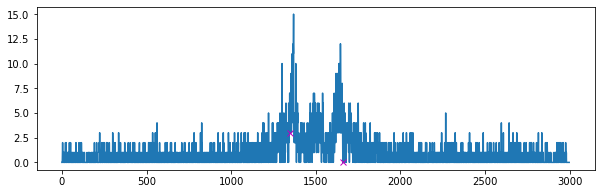

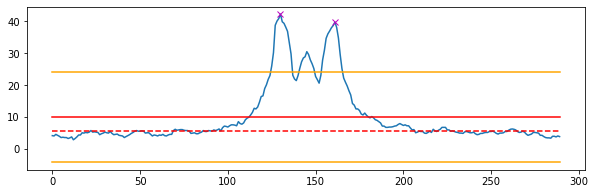

---------------------------------------------------
power method


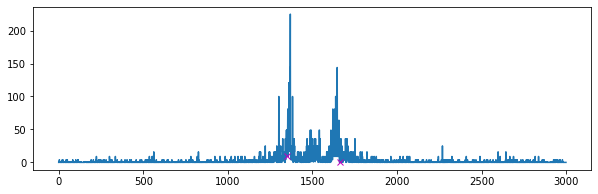

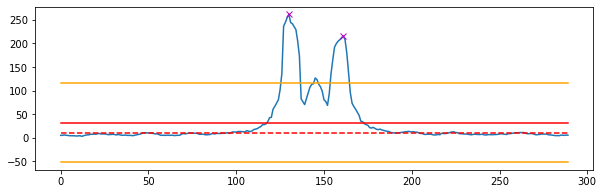

---------------------------------------------------
FFT metohd


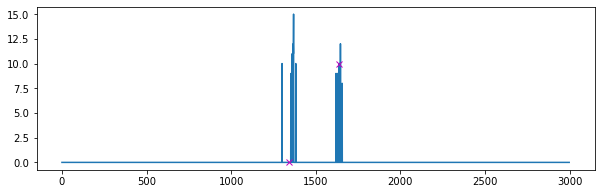

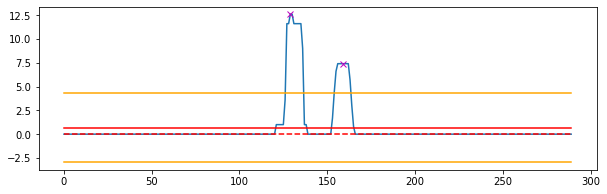

---------------------------------------------------
Original Method


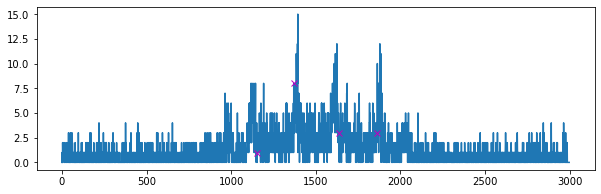

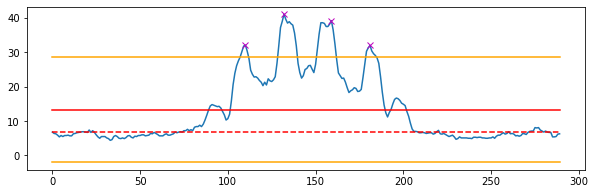

---------------------------------------------------
power method


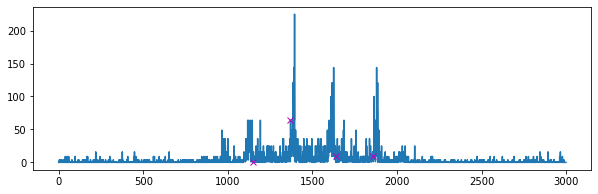

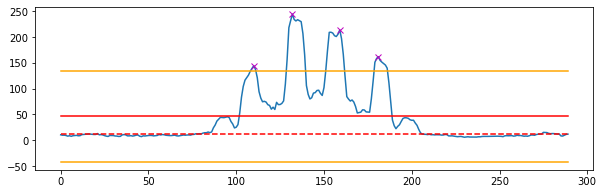

---------------------------------------------------
FFT metohd


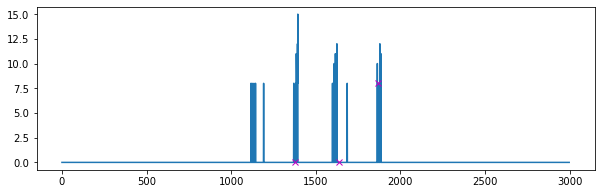

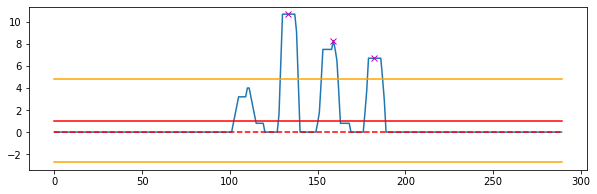

---------------------------------------------------
Original Method


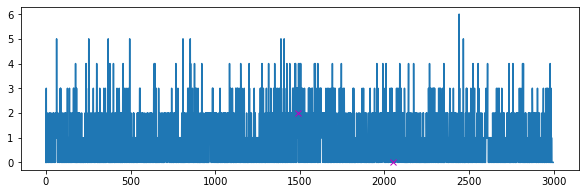

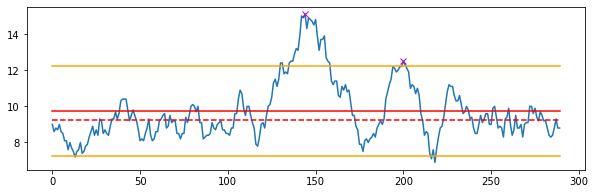

---------------------------------------------------
power method


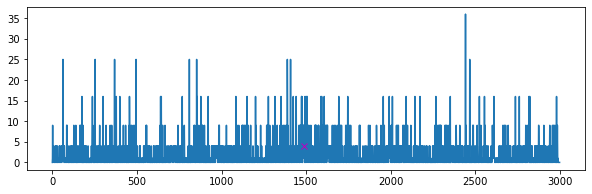

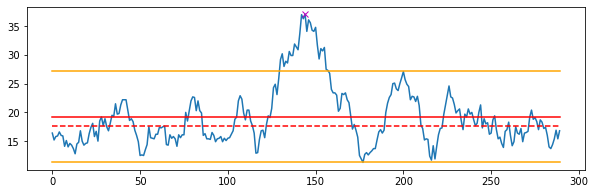

---------------------------------------------------
FFT metohd


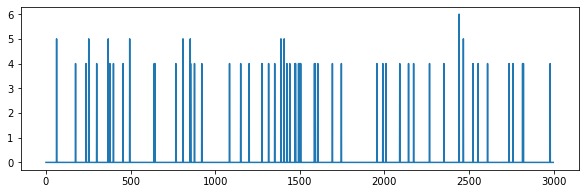

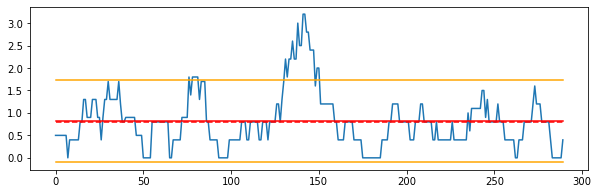

---------------------------------------------------
Original Method


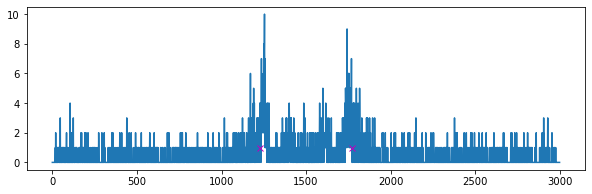

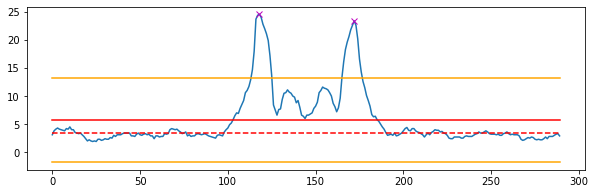

---------------------------------------------------
power method


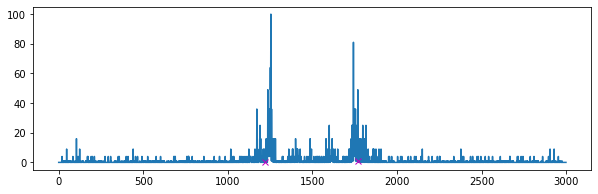

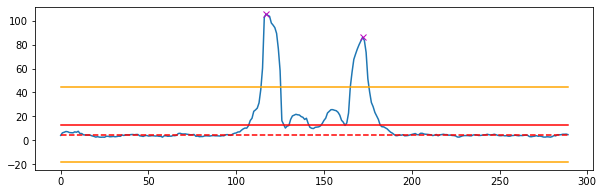

---------------------------------------------------
FFT metohd


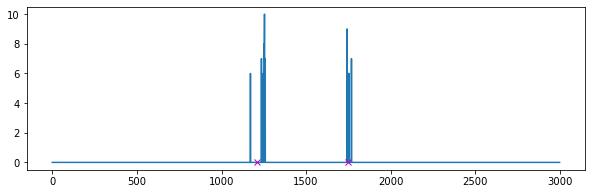

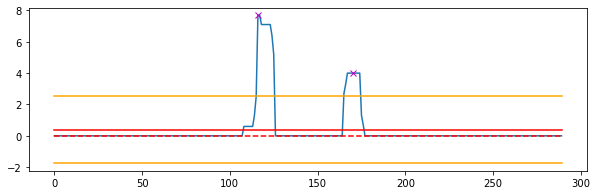

---------------------------------------------------
Original Method


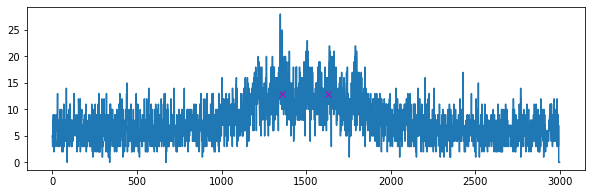

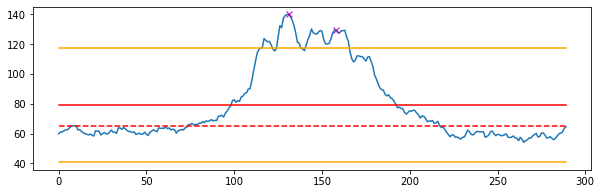

---------------------------------------------------
power method


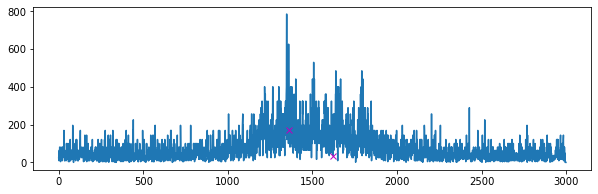

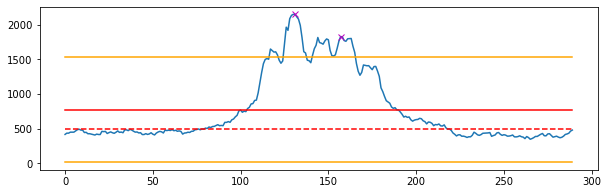

---------------------------------------------------
FFT metohd


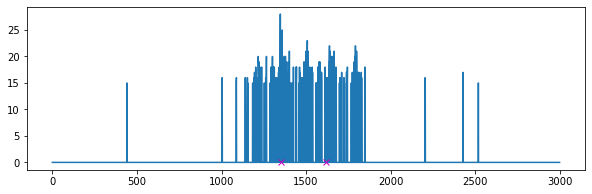

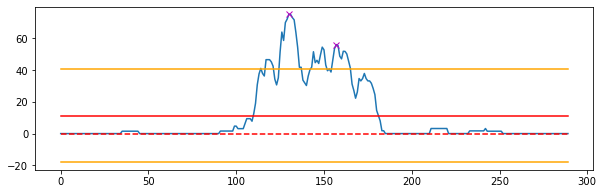

---------------------------------------------------
Original Method


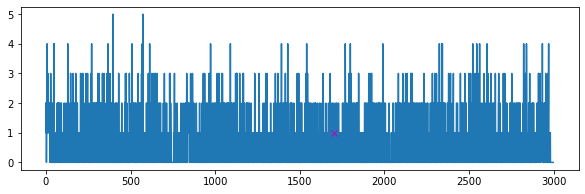

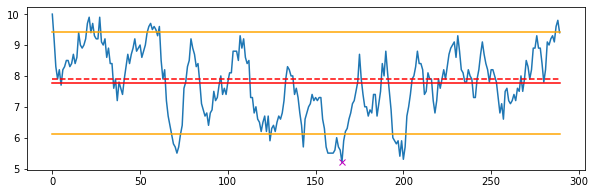

---------------------------------------------------
power method


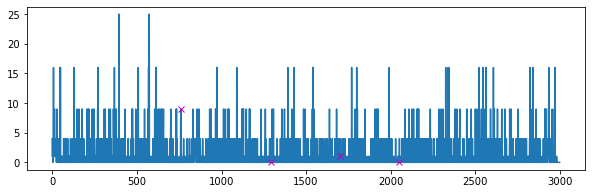

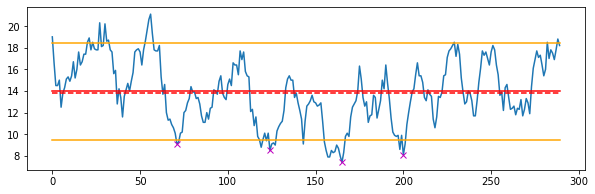

---------------------------------------------------
FFT metohd


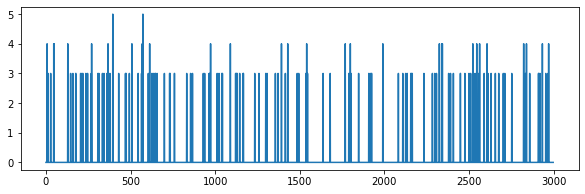

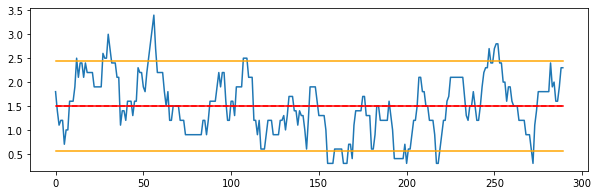

---------------------------------------------------
Original Method


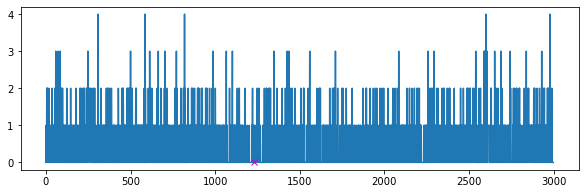

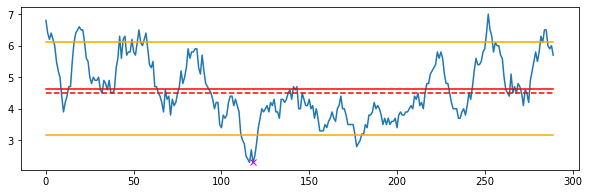

---------------------------------------------------
power method


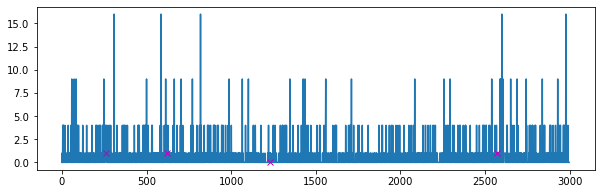

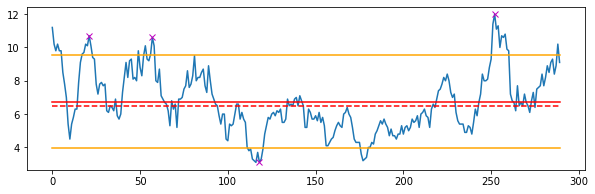

---------------------------------------------------
FFT metohd


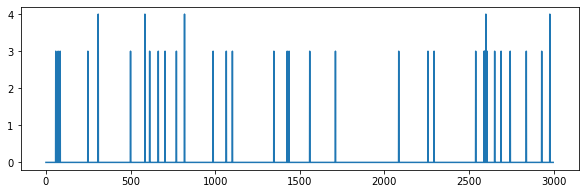

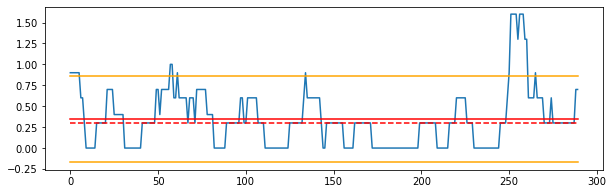

---------------------------------------------------
Original Method


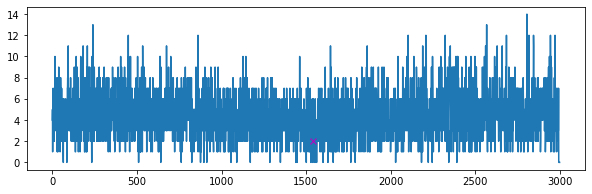

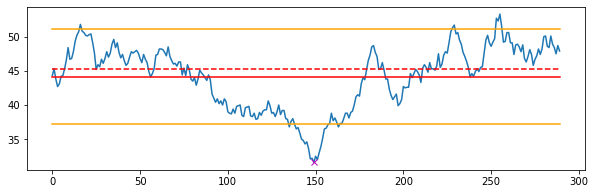

---------------------------------------------------
power method


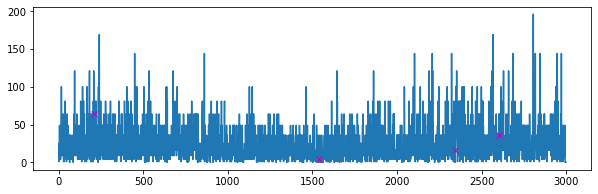

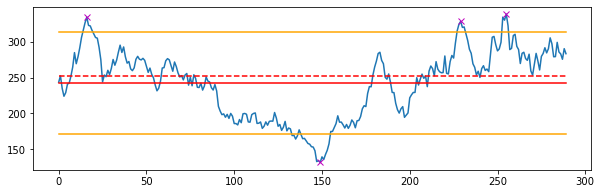

---------------------------------------------------
FFT metohd


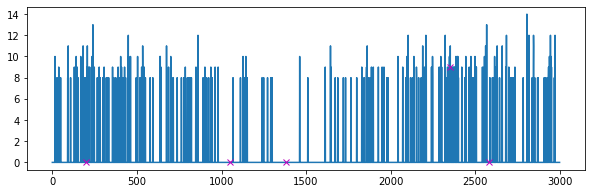

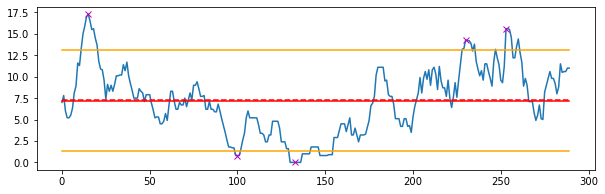

---------------------------------------------------
Original Method


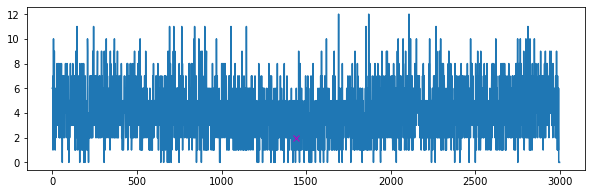

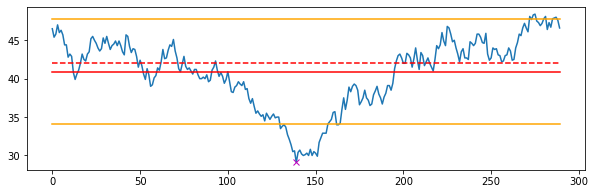

---------------------------------------------------
power method


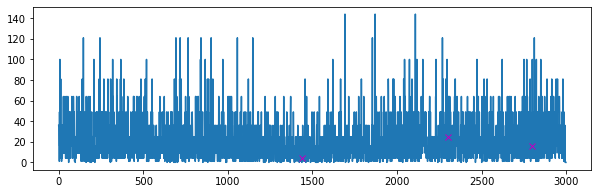

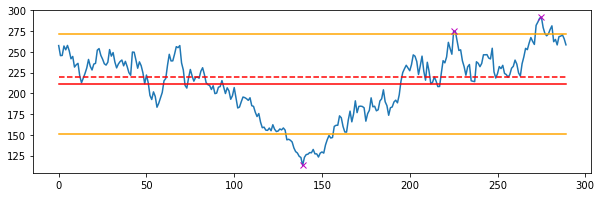

---------------------------------------------------
FFT metohd


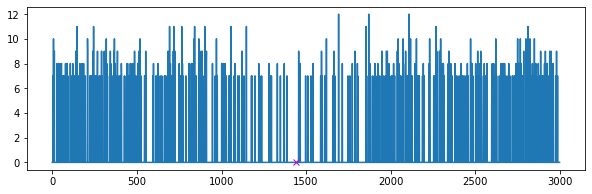

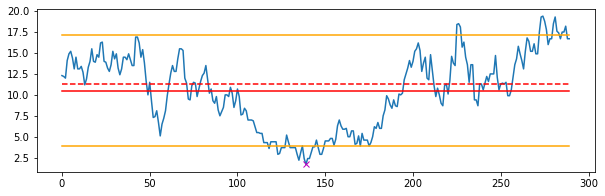

---------------------------------------------------
Original Method


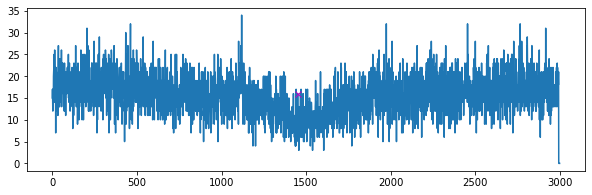

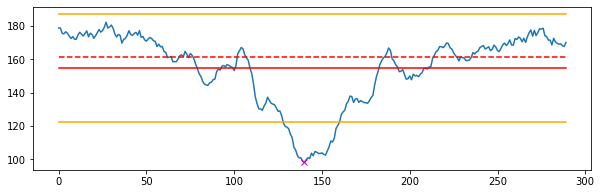

---------------------------------------------------
power method


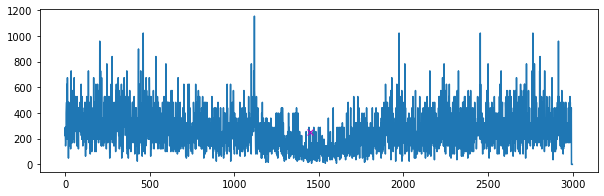

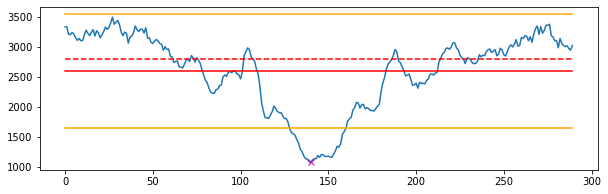

---------------------------------------------------
FFT metohd


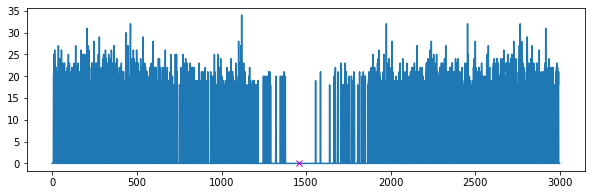

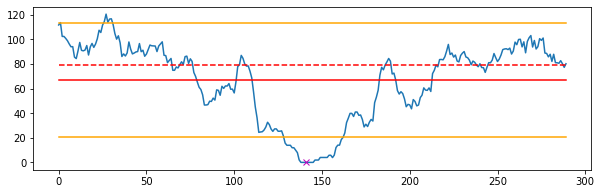

---------------------------------------------------
Original Method


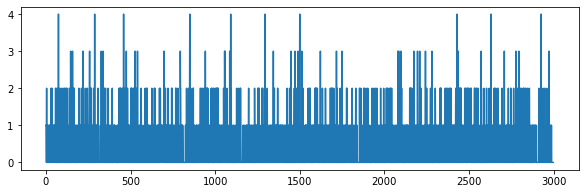

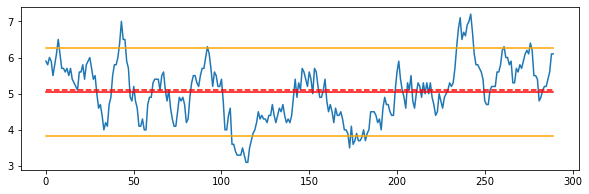

---------------------------------------------------
power method


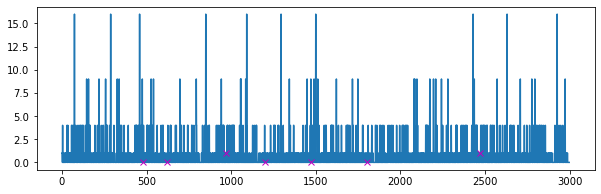

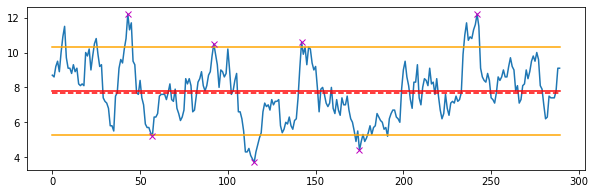

---------------------------------------------------
FFT metohd


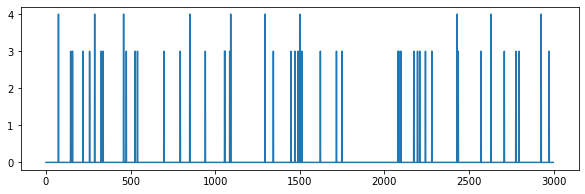

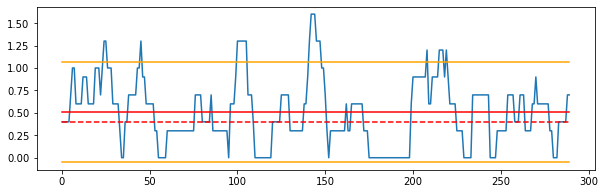

---------------------------------------------------
Original Method


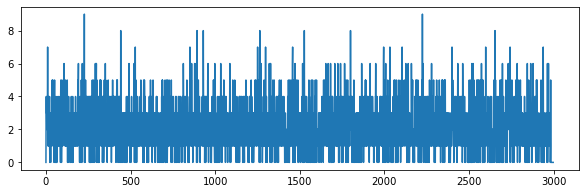

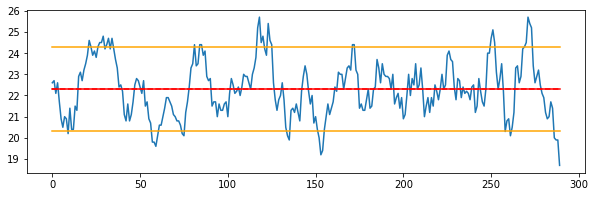

---------------------------------------------------
power method


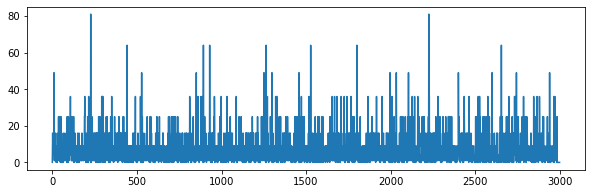

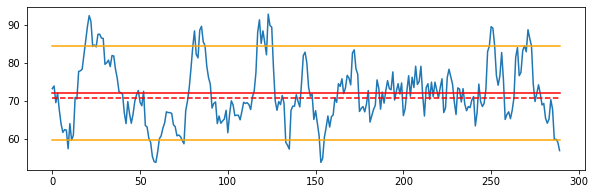

---------------------------------------------------
FFT metohd


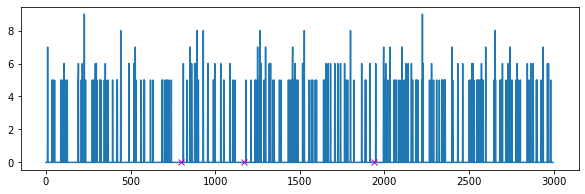

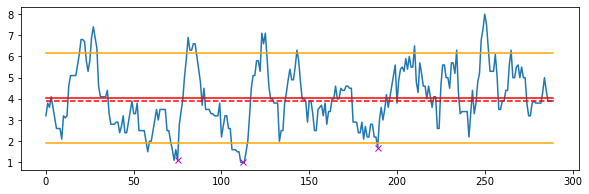

---------------------------------------------------
Original Method


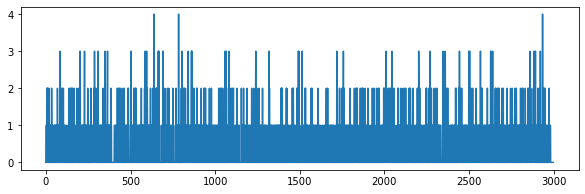

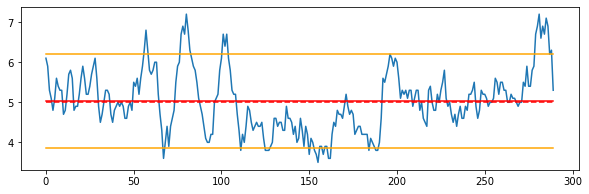

---------------------------------------------------
power method


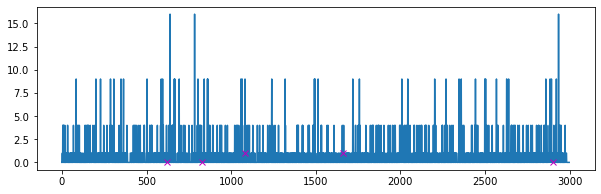

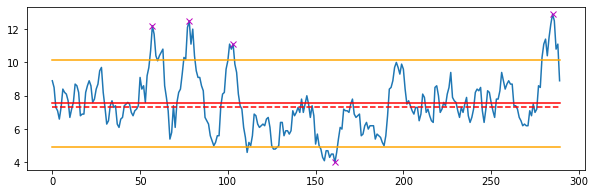

---------------------------------------------------
FFT metohd


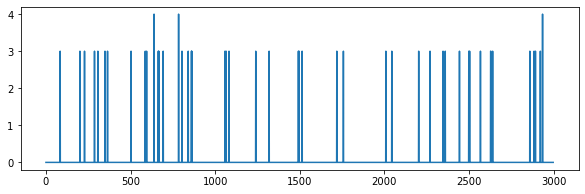

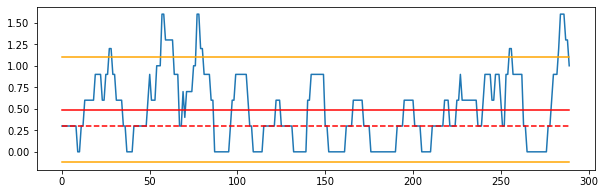

---------------------------------------------------
Original Method


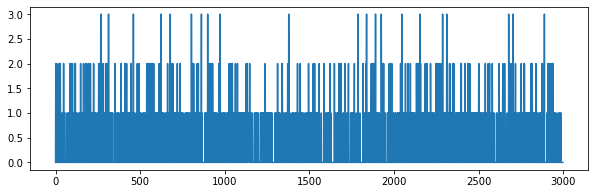

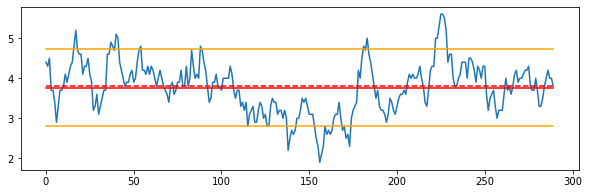

---------------------------------------------------
power method


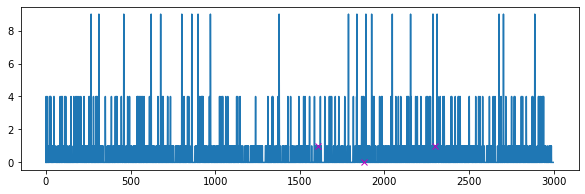

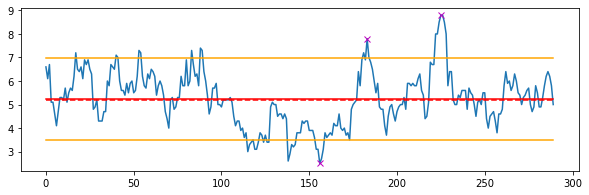

---------------------------------------------------
FFT metohd


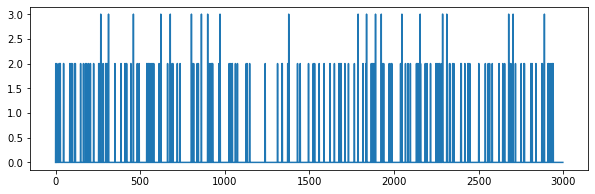

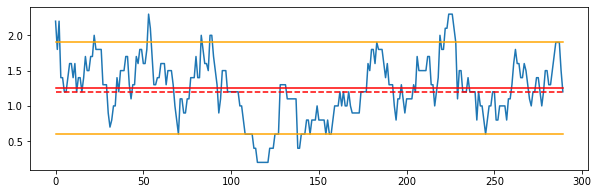

---------------------------------------------------
Original Method


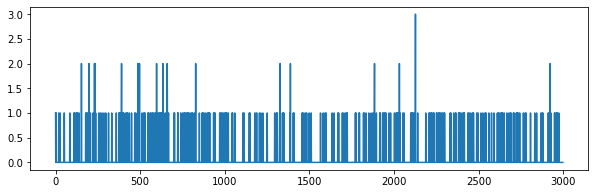

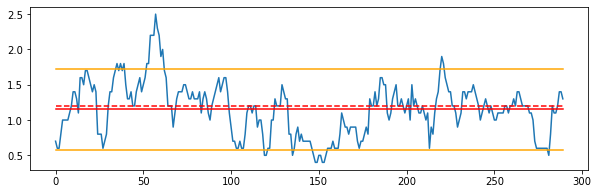

---------------------------------------------------
power method


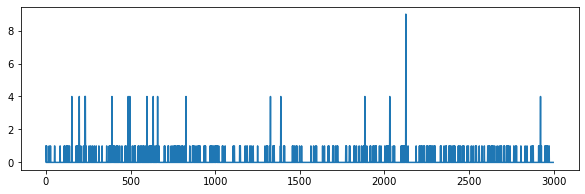

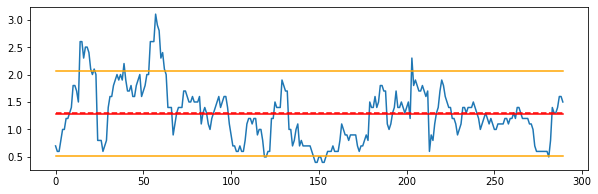

---------------------------------------------------
FFT metohd


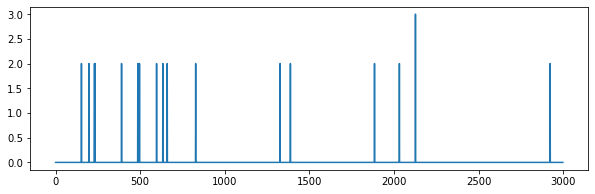

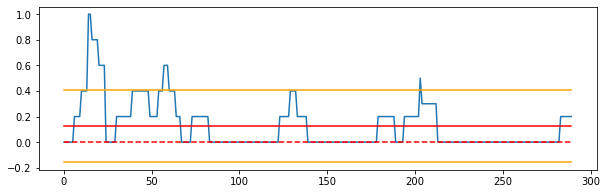

---------------------------------------------------
Original Method


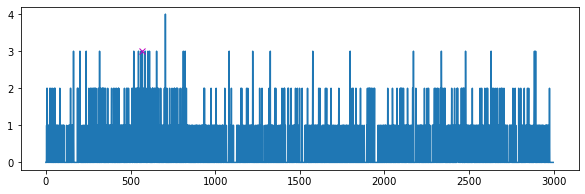

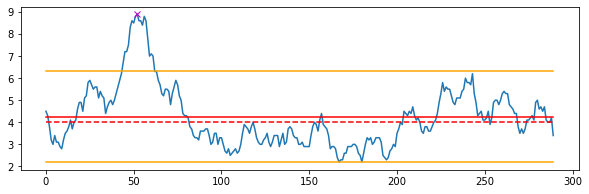

---------------------------------------------------
power method


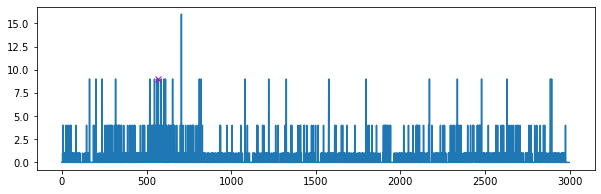

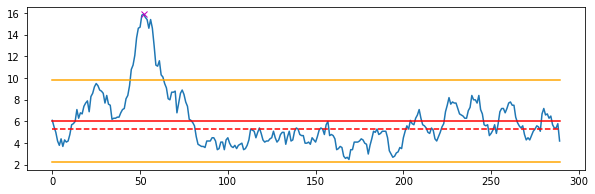

---------------------------------------------------
FFT metohd


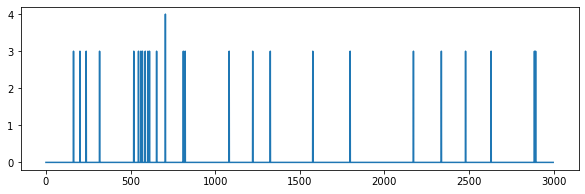

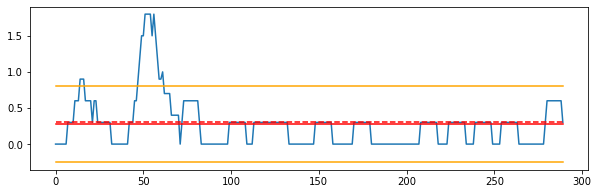

---------------------------------------------------
Original Method


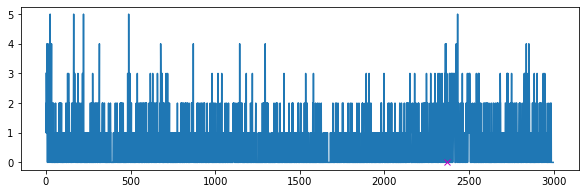

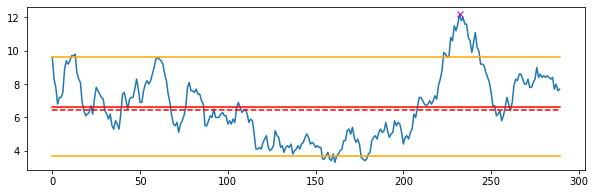

---------------------------------------------------
power method


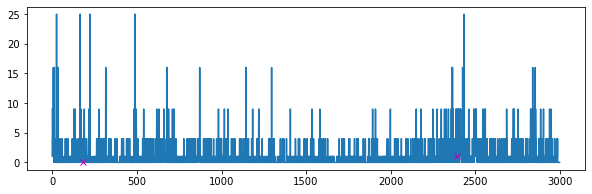

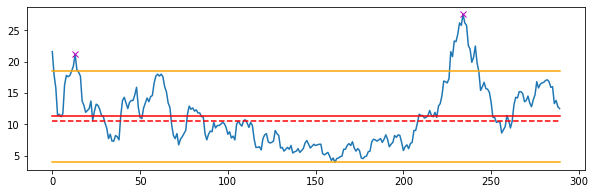

---------------------------------------------------
FFT metohd


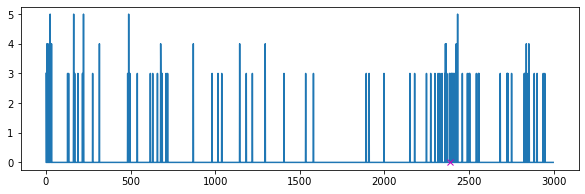

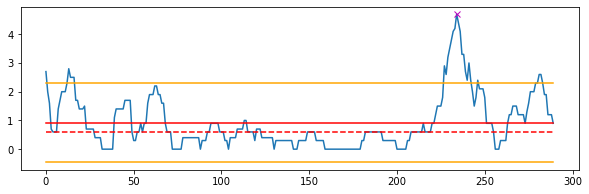

---------------------------------------------------
Original Method


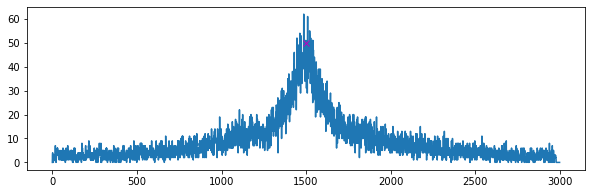

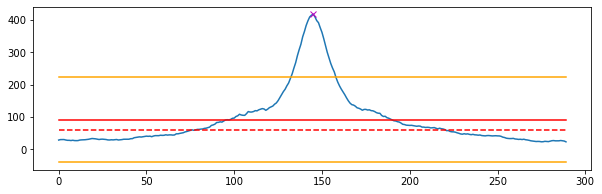

---------------------------------------------------
power method


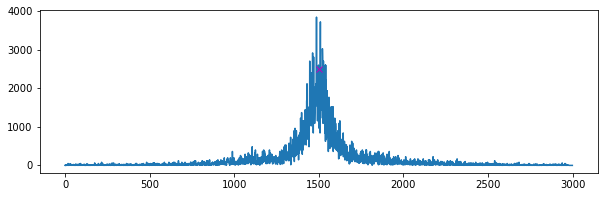

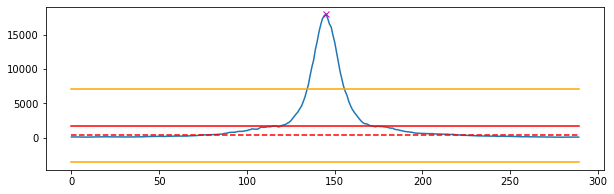

---------------------------------------------------
FFT metohd


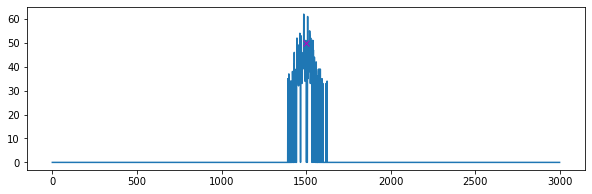

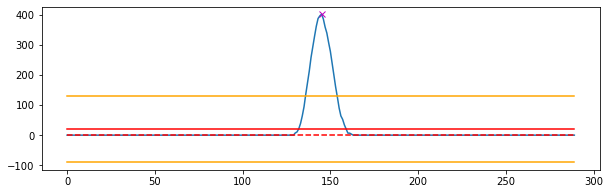

---------------------------------------------------
Original Method


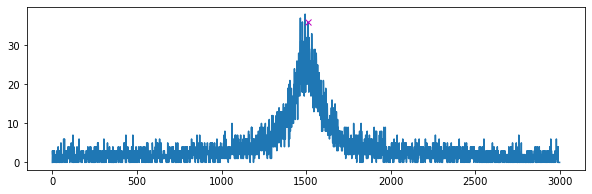

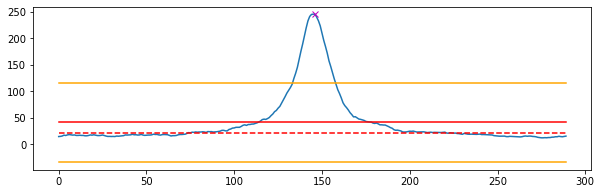

---------------------------------------------------
power method


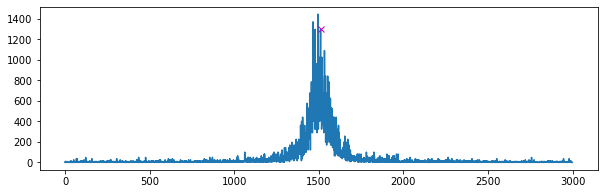

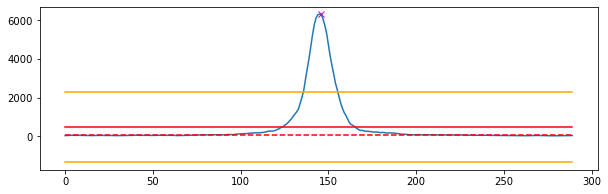

---------------------------------------------------
FFT metohd


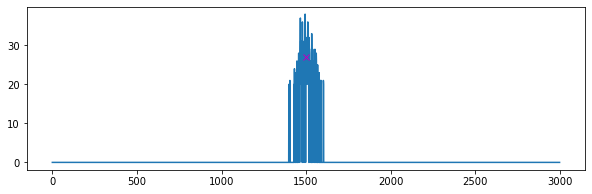

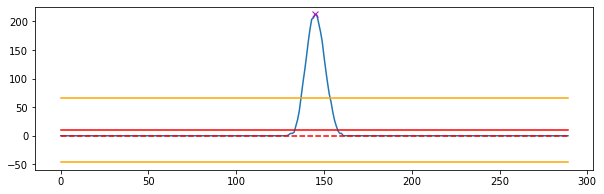

---------------------------------------------------
Original Method


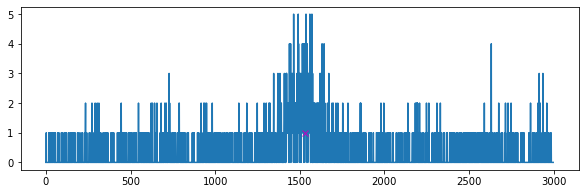

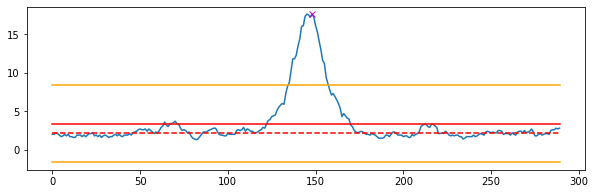

---------------------------------------------------
power method


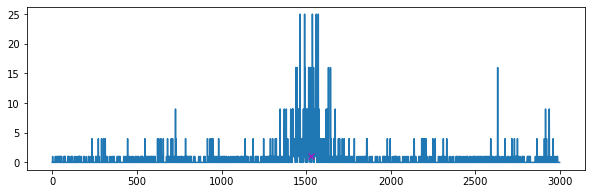

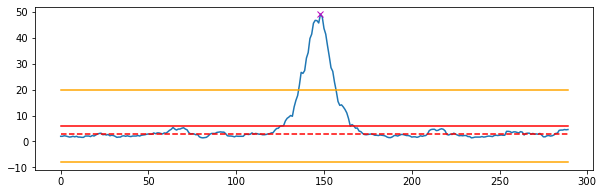

---------------------------------------------------
FFT metohd


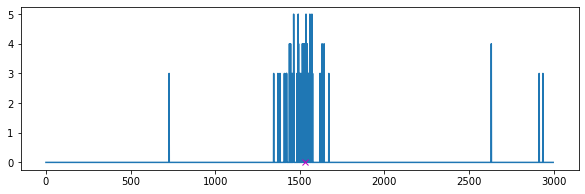

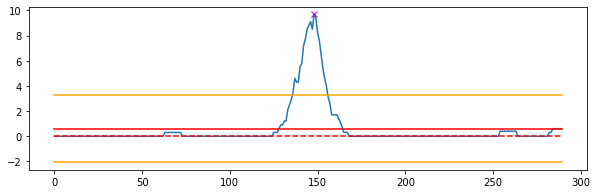

---------------------------------------------------
Original Method


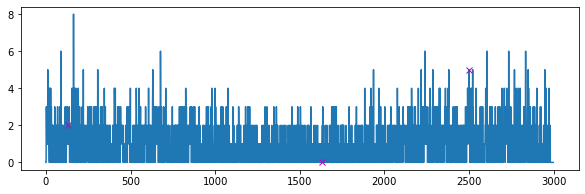

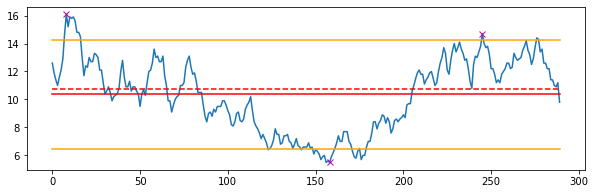

---------------------------------------------------
power method


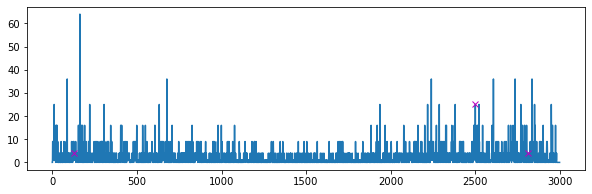

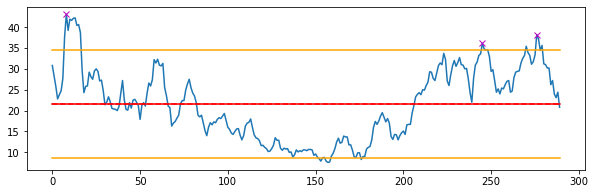

---------------------------------------------------
FFT metohd


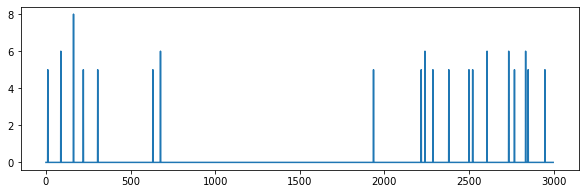

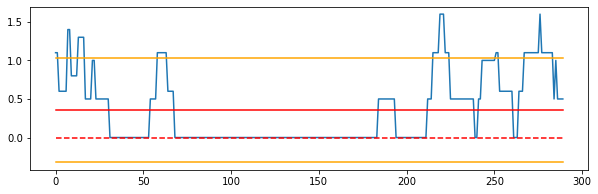

---------------------------------------------------
Original Method


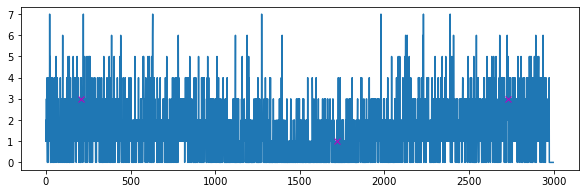

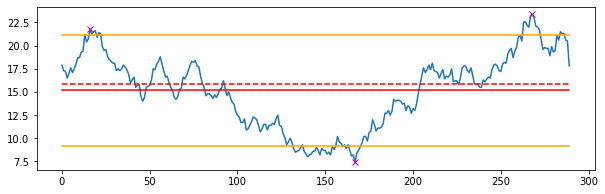

---------------------------------------------------
power method


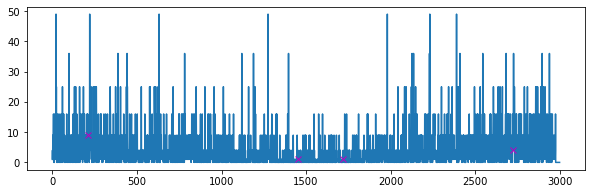

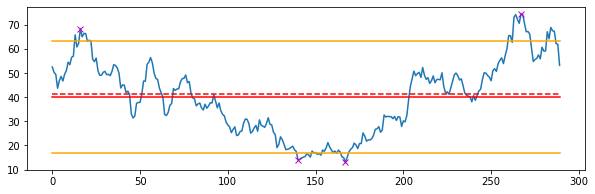

---------------------------------------------------
FFT metohd


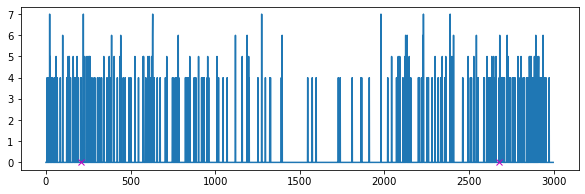

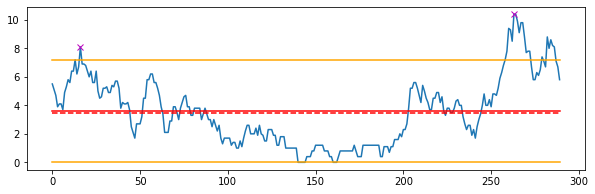

---------------------------------------------------
Original Method


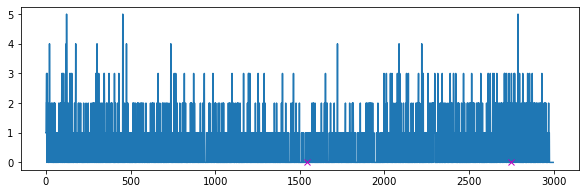

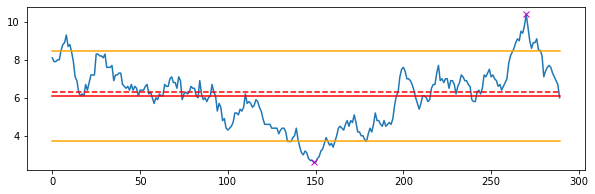

---------------------------------------------------
power method


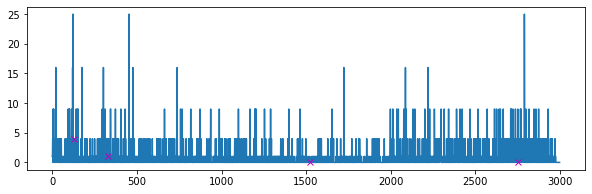

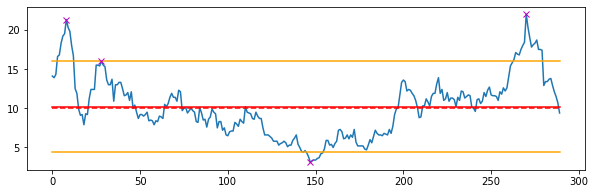

---------------------------------------------------
FFT metohd


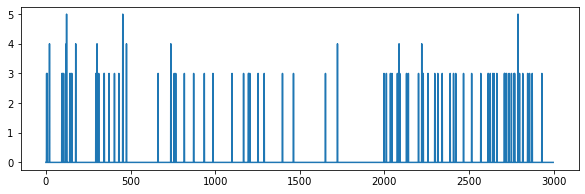

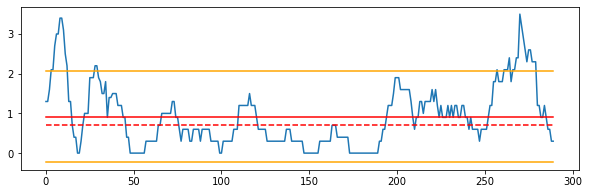

---------------------------------------------------
Original Method


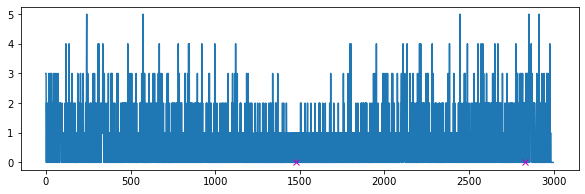

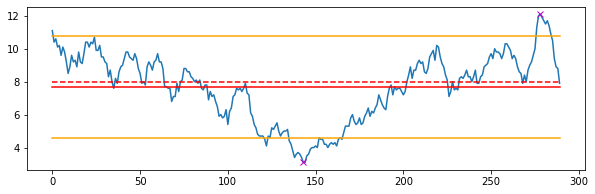

---------------------------------------------------
power method


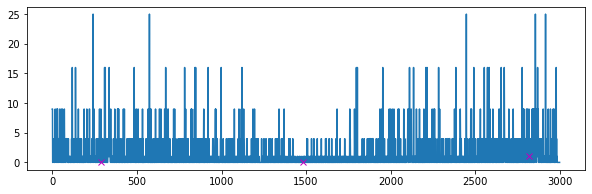

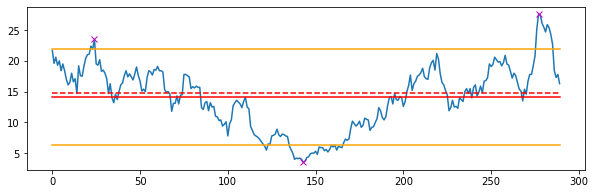

---------------------------------------------------
FFT metohd


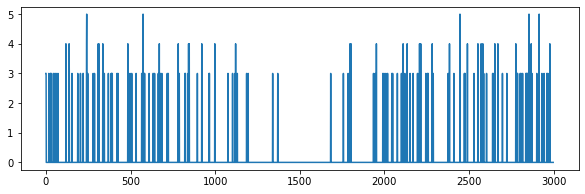

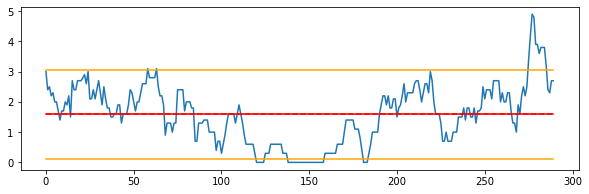

---------------------------------------------------
Original Method


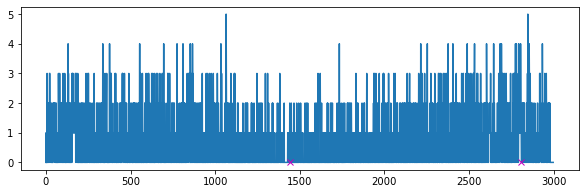

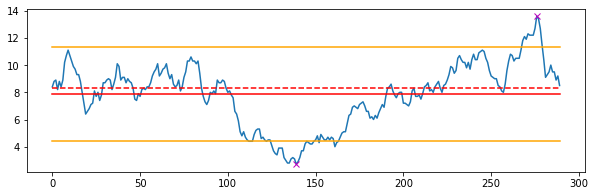

---------------------------------------------------
power method


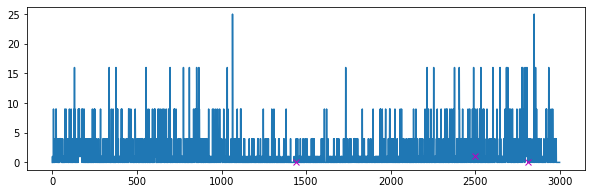

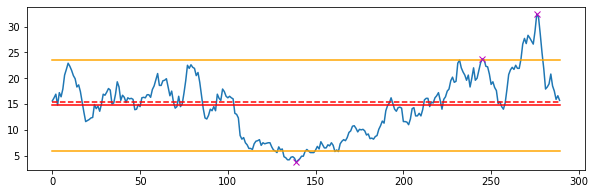

---------------------------------------------------
FFT metohd


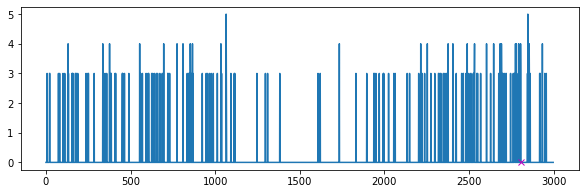

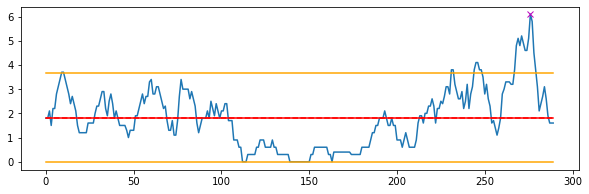

---------------------------------------------------
Original Method


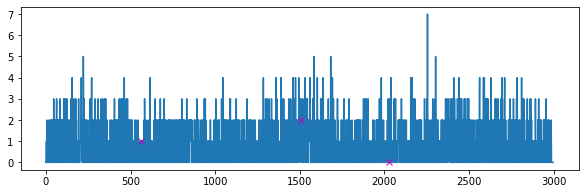

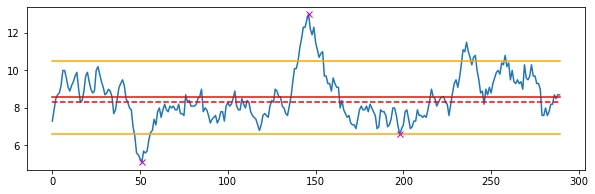

---------------------------------------------------
power method


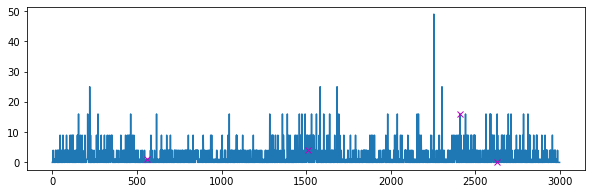

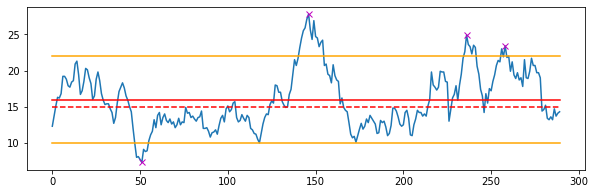

---------------------------------------------------
FFT metohd


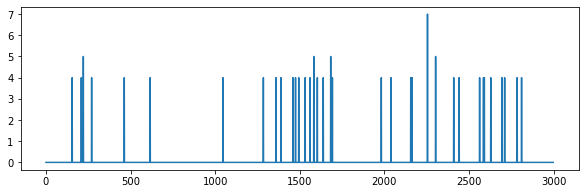

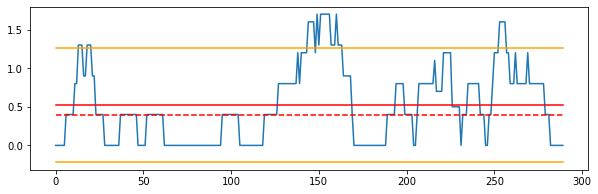

---------------------------------------------------
Original Method


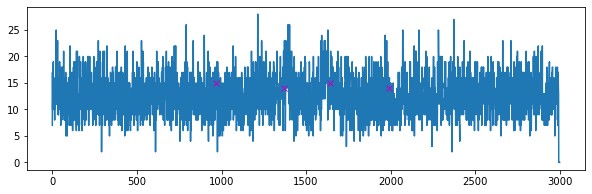

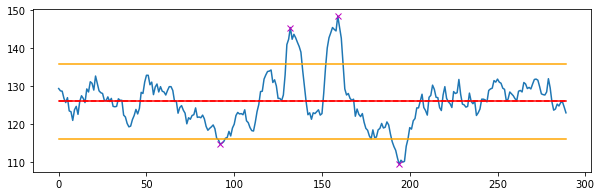

---------------------------------------------------
power method


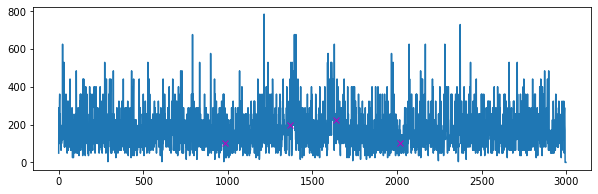

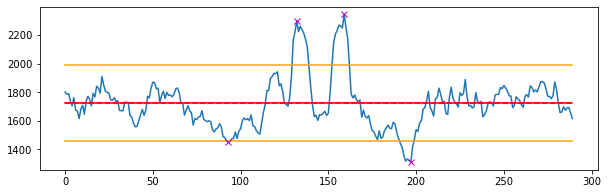

---------------------------------------------------
FFT metohd


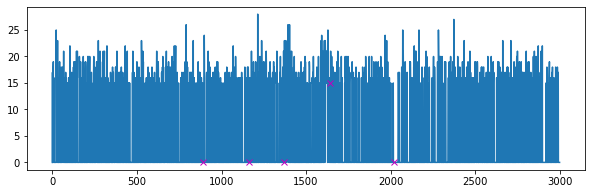

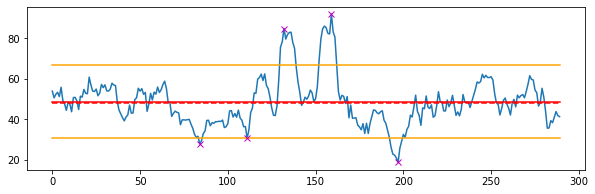

---------------------------------------------------
Original Method


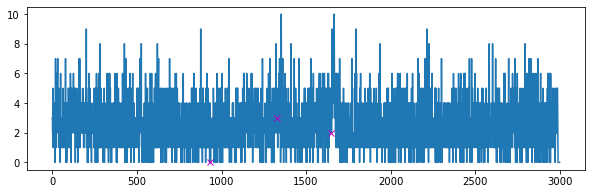

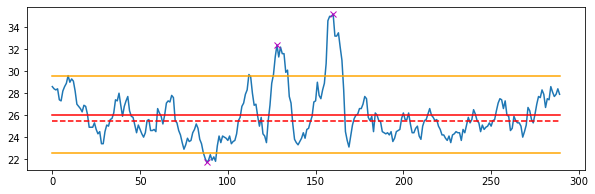

---------------------------------------------------
power method


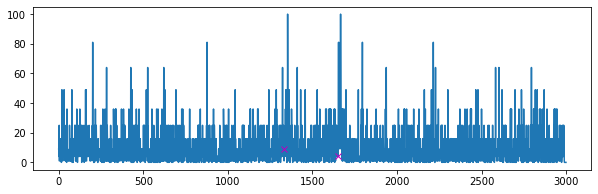

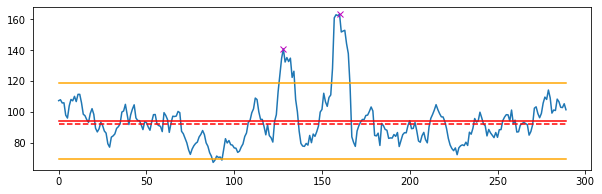

---------------------------------------------------
FFT metohd


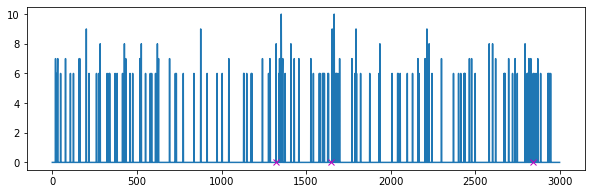

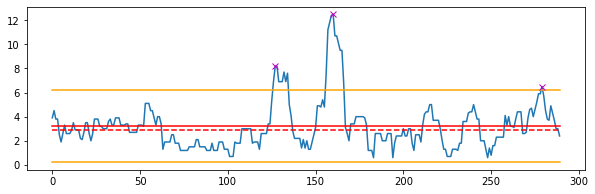

---------------------------------------------------
Original Method


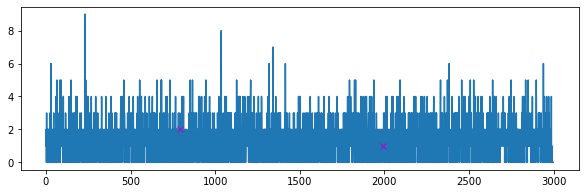

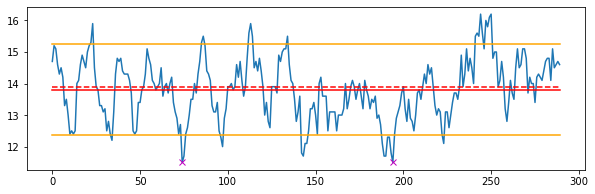

---------------------------------------------------
power method


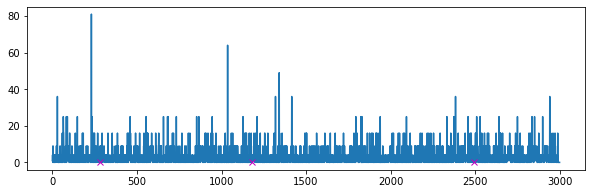

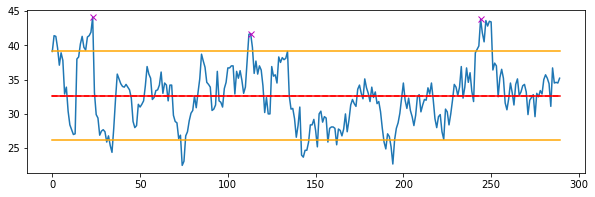

---------------------------------------------------
FFT metohd


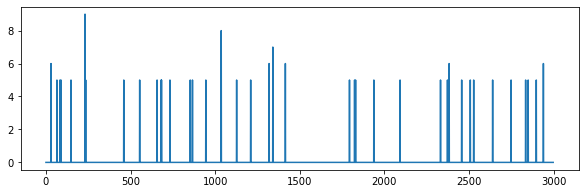

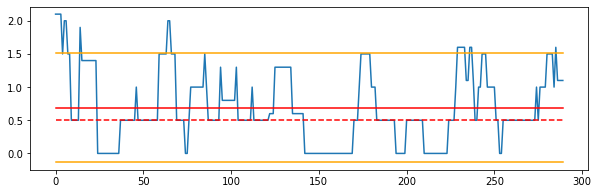

---------------------------------------------------
Original Method


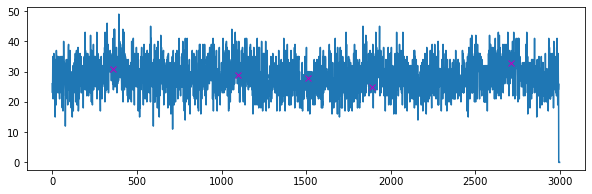

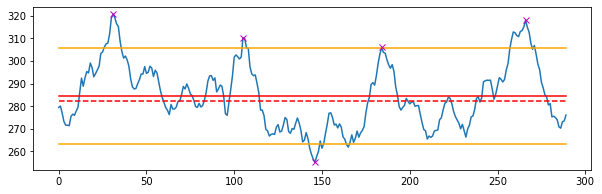

---------------------------------------------------
power method


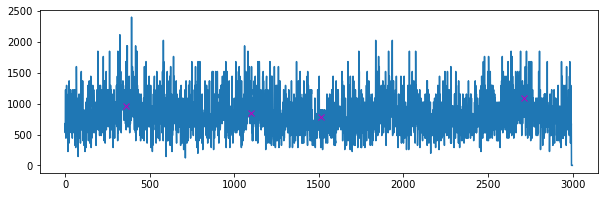

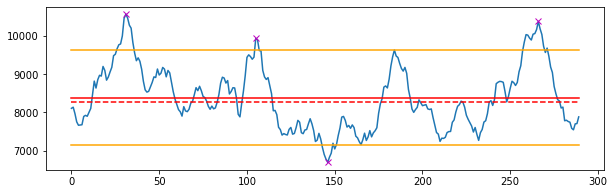

---------------------------------------------------
FFT metohd


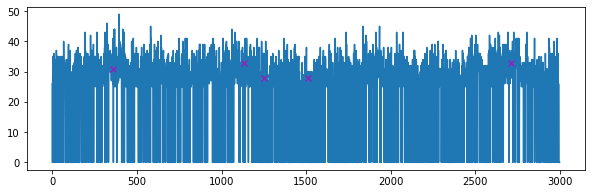

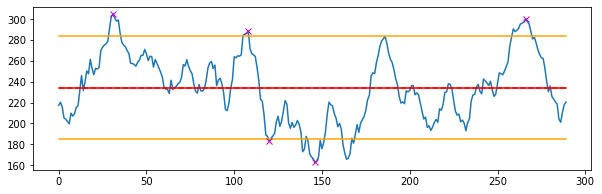

---------------------------------------------------


In [79]:
def main():
    '''
    Find the peak by  input of argparse
    '''

    my_args = input_parser()
    # get the input from argparse
    Motif_distribution = my_args.Motif_distribution
    exponential = my_args.exponential
    self_exponential = my_args.self_exponential
    FFT = my_args.FFT
    
    
    #trigger the func
    file_name = 'SRR574824_filtereddata.csv'
    find_peak_method(file_name, Motif_distribution, exponential, self_exponential, FFT)




if __name__ == "__main__":
    main()
    